In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from elasticsearch import Elasticsearch, helpers
import zipfile
from sklearn.preprocessing import MultiLabelBinarizer

# 讀取文件

In [3]:
# es = Elasticsearch("https://e32aaa94f81549368f75827f1e5da659.us-central1.gcp.cloud.es.io/",api_key=("g1i_hJIBR8AYR_FZHqsZ", "NgU5E6CkSJmd1t8uuljJJA"))

# def fetch_all_data_with_scroll(
#     es_client, index_name, scroll_timeout="5m", batch_size=1000
# ):
#     all_hits = []  # 用来儲存所有查尋到的文檔

#     # 初始查詢，指定要查詢的column
#     response = es_client.search(
#         index=index_name,
#         body={
#             "_source": [
#                 "steamId",
#                 "tags",
#                 "genres",
#                 "copiesSold",
#                 "countryData",
#                 "players",
#                 "avgPlaytime",
#                 "revenue",
#                 "history",
#             ],
#             "query": {"match_all": {}},  # 使用 match_all 查詢所有指定column的數據
#             "size": batch_size,
#         },
#         scroll=scroll_timeout,
#     )

#     scroll_id = response["_scroll_id"]
#     hits = response["hits"]["hits"]

#     try:
#         # 滾動提取數據
#         while len(hits) > 0:
#             # 直接將每條數據添加到 all_hits 列表中
#             for hit in hits:
#                 source = hit["_source"]
#                 all_hits.append(source)

#             # 滾動到下一批數據
#             response = es_client.scroll(scroll_id=scroll_id, scroll=scroll_timeout)
#             scroll_id = response["_scroll_id"]
#             hits = response["hits"]["hits"]
#     except Exception as e:
#         print(f"Error occurred during scrolling: {e}")
#     finally:
#         # 清除 scroll
#         es_client.clear_scroll(scroll_id=scroll_id)

#     # 將所有數據轉換為 DataFrame
#     df = pd.DataFrame(all_hits)
#     return df


In [5]:
# 執行並保存不同索引的資料為 DataFrame
# df_aaa = fetch_all_data_with_scroll(es, "game_data_aaa")
# df_aa = fetch_all_data_with_scroll(es, "game_data_aa")

In [4]:
# df_indie = fetch_all_data_with_scroll(es, "game_data_indie")

In [67]:
# df_aaa.to_json('game_data_aaa.json', orient='records', indent=4)
# df_aa.to_json('game_data_aa.json', orient='records', indent=4)
# df_indie.to_json('game_data_indie.json', orient='records', indent=4)

In [ ]:
df_aaa = pd.read_json('game_data_aaa.json')
df_aa = pd.read_json('game_data_aa.json')
df_indie = pd.read_json('game_data_indie.json')

In [8]:
df_aaa = pd.read_csv('game_data_aaa.csv')
df_aa = pd.read_csv('game_data_aa.csv')
df_indie = pd.read_csv('game_data_indie.csv')

In [6]:
# 把缺countryData的資料都捨棄
df_aaa  = df_aaa [df_aaa ["countryData"].notna()]
df_aa  = df_aa [df_aa ["countryData"].notna()]
df_indie  = df_indie [df_indie ["countryData"].notna()]

In [4]:
# df_aaa = pd.DataFrame(aaa)
# df_aa = pd.DataFrame(aa)
# df_indie = pd.DataFrame(indie)

# 文件合併

In [7]:
# 增加column標註publisherClass以利後續分辨
df_aaa["publisher"] = "AAA"
df_aa["publisher"] = "AA"
df_indie["publisher"] = "indie"

In [8]:
df = pd.concat([df_aaa, df_aa, df_indie], ignore_index=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19137 entries, 0 to 19136
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   steamId      19137 non-null  object 
 1   avgPlaytime  19137 non-null  float64
 2   tags         19137 non-null  object 
 3   genres       19137 non-null  object 
 4   countryData  19137 non-null  object 
 5   history      19137 non-null  object 
 6   copiesSold   19137 non-null  int64  
 7   revenue      19137 non-null  float64
 8   players      19137 non-null  int64  
 9   publisher    19137 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 1.5+ MB


In [10]:
df.to_json('df.json')

In [3]:
df = pd.read_json('df.json')

# 整理countryData的資料

In [4]:
df_country = df[["steamId", "countryData"]].reset_index(drop=True)

In [5]:
df_country

,steamId,countryData
0,2358720,"{'cn': 80.4, 'us': 3, 'ru': 1.4, 'gb': 0.8, 'b..."
1,570,"{'ru': 31, 'ua': 11, 'us': 9, 'jp': 6, 'cn': 5}"
2,1172470,"{'cn': 27.1, 'us': 13.3, 'ru': 6.7, 'br': 3.2,..."
3,730,"{'cn': 22.4, 'us': 10.2, 'ru': 8.9, 'br': 4.2,..."
4,578080,"{'cn': 34.3, 'us': 8.5, 'ru': 7.5, 'tr': 3.7, ..."
...,...,...
19263,2968050,"{'ru': 83.3, 'cn': 0, 'us': 0, 'de': 0, 'gb': ..."
19264,2714910,"{'it': 45.5, 'us': 27.3, 'de': 9.1, 'pl': 9.1,..."
19265,698320,{'tr': 17.6}
19266,825610,"{'ru': 21.4, 'br': 8.6, 'ua': 7.1, 'de': 5.7, ..."


In [6]:
# 將countryData資料展開
country_expand = pd.json_normalize(df_country["countryData"])

In [7]:
country_expand

,cn,us,ru,gb,br,hk,ca,de,tr,jp,...,gl,fk,uz,do,gd,mp,xk,py,sl,lk
0,80.4,3.0,1.4,0.8,0.7,0.6,0.5,0.5,0.4,0.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.0,9.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,27.1,13.3,6.7,2.3,3.2,1.0,2.8,2.8,3.1,2.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,22.4,10.2,8.9,2.1,4.2,0.6,2.6,3.2,3.8,1.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,34.3,8.5,7.5,1.8,3.3,0.8,2.3,2.9,3.7,2.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19263,0.0,0.0,83.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19264,0.0,27.3,0.0,0.0,0.0,0.0,0.0,9.1,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19266,5.7,4.3,21.4,NaN,8.6,NaN,NaN,5.7,4.3,4.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# 合併steamId
df_country_raw = pd.concat(
    [df_country["steamId"].reset_index(drop=True), country_expand], axis=1
)

In [9]:
df_country_raw

,steamId,cn,us,ru,gb,br,hk,ca,de,tr,...,gl,fk,uz,do,gd,mp,xk,py,sl,lk
0,2358720,80.4,3.0,1.4,0.8,0.7,0.6,0.5,0.5,0.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,570,5.0,9.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1172470,27.1,13.3,6.7,2.3,3.2,1.0,2.8,2.8,3.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,730,22.4,10.2,8.9,2.1,4.2,0.6,2.6,3.2,3.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,578080,34.3,8.5,7.5,1.8,3.3,0.8,2.3,2.9,3.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19263,2968050,0.0,0.0,83.3,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19264,2714910,0.0,27.3,0.0,0.0,0.0,0.0,0.0,9.1,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19265,698320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19266,825610,5.7,4.3,21.4,NaN,8.6,NaN,NaN,5.7,4.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# 將缺值一率補0
df_country_raw.fillna(0, inplace=True)

In [11]:
# 整理players資料表，並將players人數乘入countryData的佔比
df_players = round(df_country_raw[df_country_raw.columns[1:]].multiply(df["players"].reset_index(drop=True), axis=0)/ 100,2)

In [12]:
# 再次與steamId合併
# 得到每個遊戲在每個國家的遊玩人數
df_country = pd.concat(
    [df_country["steamId"].reset_index(drop=True), df_players], axis=1
)

# 整理genres資料表

In [13]:
df_genres = df[["steamId", "genres"]]

In [14]:
mlb = MultiLabelBinarizer()
genres_onehot = pd.DataFrame(
    mlb.fit_transform(df_genres["genres"]), columns=mlb.classes_, index=df_genres.index
)

# 將 steamId 與 one-hot 編碼結果合併
df_genres = pd.concat([df_genres[["steamId"]], genres_onehot], axis=1).reset_index(
    drop=True
)

In [15]:
df_genres = df_genres.drop(
    columns=["Indie", "Free To Play", "Free to Play", "Early Access"]
)

In [16]:
df_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19268 entries, 0 to 19267
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   steamId                19268 non-null  int64
 1   Accounting             19268 non-null  int32
 2   Action                 19268 non-null  int32
 3   Adventure              19268 non-null  int32
 4   Animation & Modeling   19268 non-null  int32
 5   Audio Production       19268 non-null  int32
 6   Casual                 19268 non-null  int32
 7   Design & Illustration  19268 non-null  int32
 8   Education              19268 non-null  int32
 9   Game Development       19268 non-null  int32
 10  Massively Multiplayer  19268 non-null  int32
 11  Movie                  19268 non-null  int32
 12  RPG                    19268 non-null  int32
 13  Racing                 19268 non-null  int32
 14  Simulation             19268 non-null  int32
 15  Sports                 19268 non-nul

In [9]:
# df_genres.to_json('df_genres.json')

In [3]:
df_genres = pd.read_json('df_genres.json')

# 整理history資料表

In [22]:
df_history = df[["steamId", "history"]]

In [23]:
df_history.iloc[0:2]

,steamId,history
0,2358720,"[{'timeStamp': '2024-08-21 16:49:35', 'reviews..."
1,570,"[{'timeStamp': '2015-01-01 16:00:00', 'reviews..."


In [24]:
df_exploded = df_history.explode("history").reset_index(drop=True)
df_exploded.iloc[0:5]

,steamId,history
0,2358720,"{'timeStamp': '2024-08-21 16:49:35', 'reviews'..."
1,2358720,"{'timeStamp': '2024-08-22 16:52:40', 'reviews'..."
2,2358720,"{'timeStamp': '2024-08-23 16:55:37', 'reviews'..."
3,2358720,"{'timeStamp': '2024-08-24 16:52:11', 'reviews'..."
4,2358720,"{'timeStamp': '2024-08-25 16:51:12', 'reviews'..."


In [25]:
# 使用 json_normalize 將 history 列中的字典展開為多個列
df_history_expanded = pd.json_normalize(df_exploded["history"])

# 合併展開後的資料與 steamId 列
df_history = pd.concat([df_exploded["steamId"], df_history_expanded], axis=1)

In [29]:
df_history["timeStamp"] = pd.to_datetime(df_history["timeStamp"])

In [30]:
# 新增一個欄位以提取年月，方便分組
df_history["year_month"] = df_history["timeStamp"].dt.to_period("M")

# 分組並抓取每個 steamId 在每個月份的第一筆
first_last_df = (
    df_history.groupby(["steamId", "year_month"])
    .agg(first_entry=("timeStamp", "first"))
    .reset_index()
)

# 將 steamId, year_month, timeStamp 組合成 tuple 進行比較
df_history["combined"] = list(
    zip(
        df_history["steamId"],
        df_history["year_month"],
        df_history["timeStamp"],
    )
)
first_last_df["first_combined"] = list(
    zip(
        first_last_df["steamId"],
        first_last_df["year_month"],
        first_last_df["first_entry"],
    )
)


# 只過濾出符合 first_entry 或 last_entry 的資料
filtered_df = df_history[df_history["combined"].isin(first_last_df["first_combined"])]

# 移除臨時欄位
filtered_df = filtered_df.drop(columns=["combined"])

In [31]:
filtered_df = filtered_df[['steamId', 'year_month', 'sales']]
filtered_df

,steamId,year_month,sales
0,2358720,2024-08,8884308.0
11,2358720,2024-09,13482020.0
41,2358720,2024-10,18320514.0
57,570,2015-01,50881638.0
59,570,2015-02,52387574.0
...,...,...,...
12788971,370310,2024-06,68.0
12789000,370310,2024-07,68.0
12789031,370310,2024-08,68.0
12789062,370310,2024-09,68.0


In [32]:
# 將 year_month 轉換為 timestamp 格式
filtered_df['year_month'] = filtered_df['year_month'].dt.to_timestamp()

# 篩選出 year_month 大於等於 2018-01-01 的行
df_filtered_sales = filtered_df[filtered_df['year_month'] >= '2018-01-01']

# 檢查結果
df_filtered_sales


,steamId,year_month,sales
0,2358720,2024-08-01,8884308.0
11,2358720,2024-09-01,13482020.0
41,2358720,2024-10-01,18320514.0
94,570,2018-01-01,111958353.0
95,570,2018-02-01,112879194.0
...,...,...,...
12788971,370310,2024-06-01,68.0
12789000,370310,2024-07-01,68.0
12789031,370310,2024-08-01,68.0
12789062,370310,2024-09-01,68.0


In [33]:
# 此函數能夠將 monthly sales growth 算出來並成立新的column
def not_cumulated_data(dataframe):
    z_list = []

    # 遍歷每一行數據
    for row in range(dataframe.shape[0]):
        if row == 0:
            # 第一行的數據直接使用 sales 值
            z_list.append(dataframe.iloc[row]["sales"])
        else:
            # 比較當前行與前一行的 steamId
            if dataframe.iloc[row]["steamId"] == dataframe.iloc[row - 1]["steamId"]:
                # 計算 sales 的差異
                x = dataframe.iloc[row]["sales"] - dataframe.iloc[row - 1]["sales"]
                z_list.append(x)
            else:
                # 如果 steamId 不同，直接取當前行的 sales 值
                y = dataframe.iloc[row]["sales"]
                z_list.append(y)

    # 使用 .loc 添加新的列，避免警告
    dataframe.loc[:, "monthly_sales_growth"] = z_list

    return dataframe

In [34]:
df_history_sales = not_cumulated_data(df_filtered_sales)

C:\Users\student\AppData\Local\Temp\ipykernel_2724\2197948307.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, "monthly_sales_growth"] = z_list


In [35]:
df_history_sales = df_history_sales.rename(columns={"data_sales": "monthly_sales_growth"})

In [36]:
df_history_sales

,steamId,year_month,sales,monthly_sales_growth
0,2358720,2024-08-01,8884308.0,8884308.0
11,2358720,2024-09-01,13482020.0,4597712.0
41,2358720,2024-10-01,18320514.0,4838494.0
94,570,2018-01-01,111958353.0,111958353.0
95,570,2018-02-01,112879194.0,920841.0
...,...,...,...,...
12788971,370310,2024-06-01,68.0,0.0
12789000,370310,2024-07-01,68.0,0.0
12789031,370310,2024-08-01,68.0,0.0
12789062,370310,2024-09-01,68.0,0.0


In [37]:
# df_history_sales_re與df_country_raw作融合，以算出每個遊戲在每個國家的銷售數量
df_history_sales_country = df_history_sales.merge(df_country_raw, on='steamId', how='right')

In [38]:
df_history_sales_country

,steamId,year_month,sales,monthly_sales_growth,cn,us,ru,gb,br,hk,...,gl,fk,uz,do,gd,mp,xk,py,sl,lk
0,2358720,2024-08-01,8884308.0,8884308.0,80.4,3.0,1.4,0.8,0.7,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2358720,2024-09-01,13482020.0,4597712.0,80.4,3.0,1.4,0.8,0.7,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2358720,2024-10-01,18320514.0,4838494.0,80.4,3.0,1.4,0.8,0.7,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,570,2018-01-01,111958353.0,111958353.0,5.0,9.0,31.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,570,2018-02-01,112879194.0,920841.0,5.0,9.0,31.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1154852,370310,2024-06-01,68.0,0.0,10.9,12.9,7.5,4.8,6.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1154853,370310,2024-07-01,68.0,0.0,10.9,12.9,7.5,4.8,6.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1154854,370310,2024-08-01,68.0,0.0,10.9,12.9,7.5,4.8,6.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1154855,370310,2024-09-01,68.0,0.0,10.9,12.9,7.5,4.8,6.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
# 將每個標籤類別列乘以 monthly_sales_growth 值，這樣只有標籤為 1 的列會保留 sales 值，0 的列保持不變
for column in df_history_sales_country.columns[4:]:  # 從第4列開始，因為前面是非標籤的列
    df_history_sales_country[column] = round(df_history_sales_country[column] * (df_history_sales_country["monthly_sales_growth"])/100, 2)

# 最後得出每個遊戲在每個國家的每月銷量

In [40]:
df_history_sales_country

,steamId,year_month,sales,monthly_sales_growth,cn,us,ru,gb,br,hk,...,gl,fk,uz,do,gd,mp,xk,py,sl,lk
0,2358720,2024-08-01,8884308.0,8884308.0,7142983.63,266529.24,124380.31,71074.46,62190.16,53305.85,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2358720,2024-09-01,13482020.0,4597712.0,3696560.45,137931.36,64367.97,36781.70,32183.98,27586.27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2358720,2024-10-01,18320514.0,4838494.0,3890149.18,145154.82,67738.92,38707.95,33869.46,29030.96,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,570,2018-01-01,111958353.0,111958353.0,5597917.65,10076251.77,34707089.43,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,570,2018-02-01,112879194.0,920841.0,46042.05,82875.69,285460.71,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1154852,370310,2024-06-01,68.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1154853,370310,2024-07-01,68.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1154854,370310,2024-08-01,68.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1154855,370310,2024-09-01,68.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
# df_history_sales_country.to_json('df_history_sales_country.json')

In [2]:
df_history_sales_country = pd.read_json('df_history_sales_country.json')

# 繪製圖表

## 1. 前20大國家之玩家數量排名

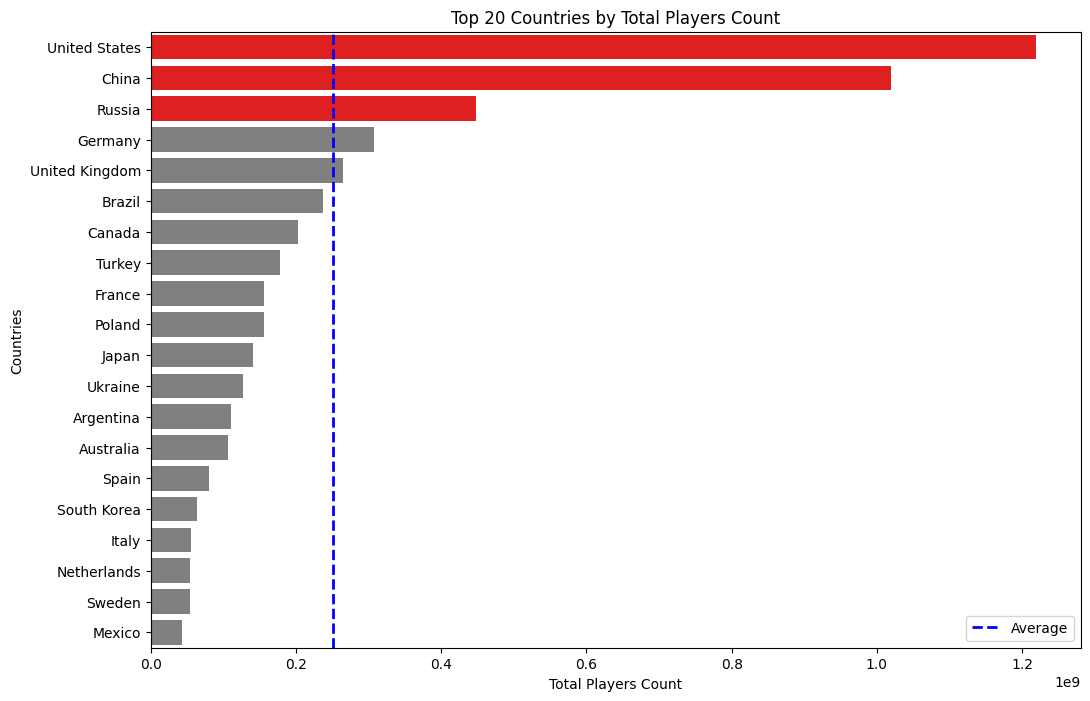

In [17]:
# 計算每個國家的總遊玩人數，並取前 20 名
top_20_country = df_country.iloc[:, 1:].sum(axis=0).nlargest(20)

# 創建顏色列表，前三名用紅色，其他用灰色
colors = ["red" if i < 3 else "gray" for i in range(len(top_20_country))]

# 前20名國家的玩家平均人數
average_play_counts = top_20_country.mean()

# 繪製橫向的柱狀圖展示前 20 名標籤的總遊玩人數
plt.figure(figsize=(12, 8))

# 使用 hue 指定顏色
sns.barplot(
    y=top_20_country.index,
    x=top_20_country.values,
    hue=top_20_country.index,
    palette=colors,
    dodge=False,
    legend=False,
)

# 添加平均值虛線
plt.axvline(
    average_play_counts, color="blue", linestyle="--", linewidth=2, label="Average"
)

# 原始國家代碼對應國家名稱的字典
country_name_map = {
    "us": "United States",
    "cn": "China",
    "ru": "Russia",
    "de": "Germany",
    "gb": "United Kingdom",
    "br": "Brazil",
    "ca": "Canada",
    "tr": "Turkey",
    "fr": "France",
    "pl": "Poland",
    "jp": "Japan",
    "ua": "Ukraine",
    "ar": "Argentina",
    "au": "Australia",
    "es": "Spain",
    "kr": "South Korea",
    "it": "Italy",
    "se": "Sweden",
    "nl": "Netherlands",
    "mx": "Mexico",
}

plt.title("Top 20 Countries by Total Players Count")
plt.xlabel("Total Players Count")
plt.ylabel("Countries")
plt.xticks(rotation=0)

# 修改y軸的國家名稱顯示為全名
plt.yticks(
    ticks=range(len(top_20_country)),
    labels=[country_name_map.get(country, country) for country in top_20_country.index],
)

plt.legend()
plt.show()

## 產出tableau繪製圖表

In [49]:
df_country.reset_index(drop=False)
map = pd.DataFrame(df_country.iloc[:, 1:].sum(axis=0), columns=["players"])
map = map.reset_index(drop=False)
map.to_excel("map.xlsx")

## 2. 前5大國家之遊玩人數的遊戲genres佔比(紅海市場)

In [17]:
# 合併兩個 DataFrame（以 steamId 為鍵）
df_combined = df_country.merge(df_genres, on="steamId")

# 計算每個標籤在不同國家的總遊玩人數
genres_country_play_counts = df_combined.iloc[:, 1:145].T.dot(df_combined.iloc[:, 145:])

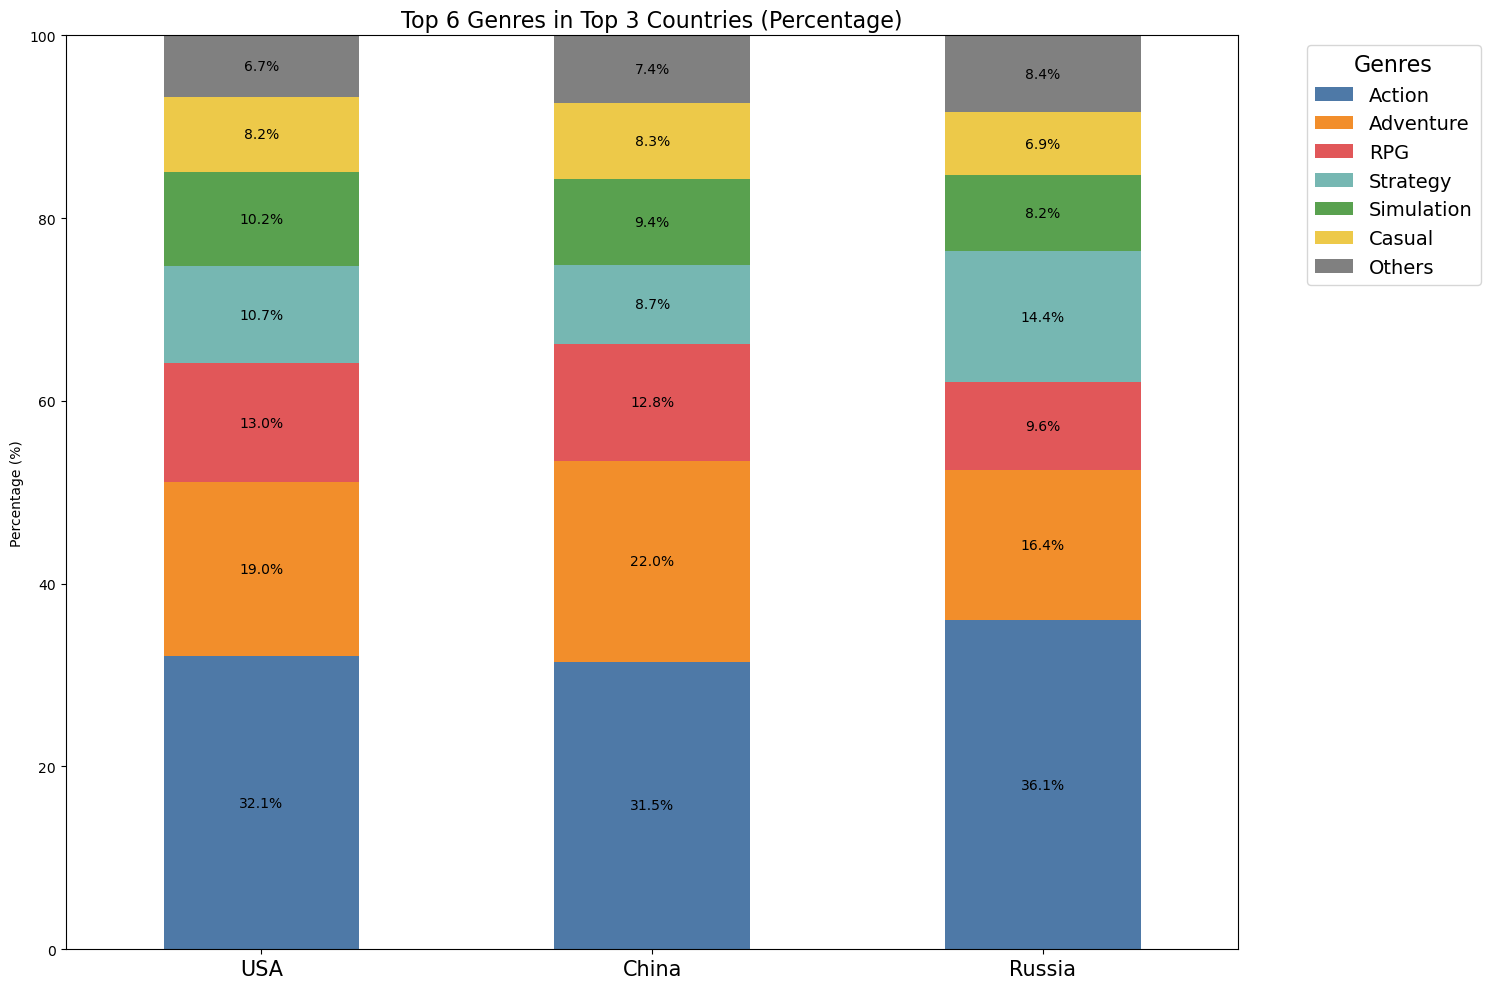

In [18]:
# 計算每個標籤的總遊玩人數，並取前 6 名
top_6_genres = genres_country_play_counts.sum(axis=0).nlargest(6).index

# 計算每個國家的總遊玩人數，並取前 3 名
top_3_countries = genres_country_play_counts.sum(axis=1).nlargest(3).index

# 過濾出前 3 名國家和前 6 名標籤的數據
filtered_data = genres_country_play_counts.loc[top_3_countries]

# 將前 6 名以外的標籤合併為 "Others"
filtered_data["Others"] = filtered_data.drop(columns=top_6_genres).sum(axis=1)

# 只保留前 6 名標籤，加上 "Others" 列
filtered_data_top3 = filtered_data[top_6_genres.to_list() + ["Others"]]

# 將數據轉換為百分比形式
country_totals = filtered_data_top3.sum(axis=1)
data_percent = filtered_data_top3.div(country_totals, axis=0) * 100

# 定義顏色：前 6 名標籤使用不同顏色，"Others" 使用灰色
colors = ["#4e79a7", "#f28e2b", "#e15759", "#76b7b2", "#59a14f", "#edc949", "gray"]

# 繪製堆疊柱狀圖，展示前 3 名國家中前 6 名標籤的百分比
ax = data_percent.plot(kind="bar", stacked=True, figsize=(15, 10), color=colors)

ax.set_title("Top 6 Genres in Top 3 Countries (Percentage)", fontsize=16)
ax.set_ylabel("Percentage (%)")
ax.set_ylim(0, 100)

# 設置國家名稱對應表，並應用到 x 軸標籤
country_names = {
    "us": "USA",
    "cn": "China",
    "ru": "Russia",
    "de": "Germany",
    "gb": "United Kingdom",
}

ax.set_xticklabels(
    [country_names.get(label.get_text(), label.get_text()) for label in ax.get_xticklabels()],
    rotation=0,
    fontsize=15,
)

# 添加標註，顯示每個國家內各標籤的百分比
for i, container in enumerate(ax.containers):
    labels = []
    for v in container.datavalues:
        if v > 0:
            label = f"{v:.1f}%"
        else:
            label = ""
        labels.append(label)
    ax.bar_label(container, labels=labels, label_type="center", fontsize=10, color="black")

# 調整圖例位置以提高可讀性
ax.legend(
    title="Genres",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize=14,
    title_fontsize=16,
)

# 顯示圖表
plt.tight_layout()
plt.show()



In [20]:
data_percent.to_csv('country_percent.csv')

## 3. 時間序列圖(藍海市場)

In [4]:
# 合併兩個 DataFrame（以 steamId 為鍵）
df_combined = df_history_sales_country.merge(df_genres,on="steamId", how='right')

In [5]:
# 將 year_month 列從 Unix 毫秒時間戳轉換為日期時間格式
df_combined['year_month'] = pd.to_datetime(df_combined['year_month'], unit='ms')

In [7]:
# 初始化一個 DataFrame，只包含 steamId
df_country_genres_sales = df_combined[['steamId', 'year_month']].copy()

# 建立一個臨時的字典來存放計算結果
temp_results = {}

# 遍歷 4:145 的每一個標籤列
for column in df_combined.columns[4:148]:
    # 對應標籤列與 145: 之後的國家列逐元素相乘
    for country_column in df_combined.columns[148:]:
        # 將結果存入字典中，而不是直接加入 DataFrame
        temp_results[f'{column}_{country_column}'] = df_combined[column] * df_combined[country_column]

# 使用 pd.concat 一次性將所有計算結果加入 DataFrame
df_country_genres_sales = pd.concat([df_country_genres_sales, pd.DataFrame(temp_results)], axis=1)

# 檢查結果
df_country_genres_sales.head()



,steamId,year_month,cn_Accounting,cn_Action,cn_Adventure,cn_Animation & Modeling,cn_Audio Production,cn_Casual,cn_Design & Illustration,cn_Education,...,lk_Education,lk_Game Development,lk_Massively Multiplayer,lk_Movie,lk_RPG,lk_Racing,lk_Simulation,lk_Sports,lk_Strategy,lk_Utilities
0,2358720,2024-08-01,0.0,7142983.63,7142983.63,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2358720,2024-09-01,0.0,3696560.45,3696560.45,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2358720,2024-10-01,0.0,3890149.18,3890149.18,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,570,2018-01-01,0.0,5597917.65,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,570,2018-02-01,0.0,46042.05,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# 依據 'year_month' 進行分組，並從第三個欄位開始將其餘欄位相加
df_sales_grouped = df_country_genres_sales.groupby('year_month').sum().reset_index()

In [9]:
# drop掉不需要的steamId
df_sales_grouped.drop(columns=['steamId'])

,year_month,cn_Accounting,cn_Action,cn_Adventure,cn_Animation & Modeling,cn_Audio Production,cn_Casual,cn_Design & Illustration,cn_Education,cn_Game Development,...,lk_Education,lk_Game Development,lk_Massively Multiplayer,lk_Movie,lk_RPG,lk_Racing,lk_Simulation,lk_Sports,lk_Strategy,lk_Utilities
0,2018-01-01,0.00,1.125254e+08,67424608.38,0.00,0.00,18379654.43,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-02-01,0.00,1.998252e+06,1535726.86,0.00,0.00,351979.98,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-03-01,0.00,5.083471e+06,3101621.23,0.00,0.00,683882.64,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018-04-01,0.00,2.196782e+06,1730715.67,0.00,0.00,295426.82,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-05-01,0.00,1.931724e+06,1646654.30,0.00,0.00,496062.61,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,2024-06-01,0.00,6.279850e+06,4921994.82,0.00,14.74,1726573.04,0.00,14.74,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78,2024-07-01,0.00,6.507648e+06,5269151.10,0.00,58.40,2228969.68,0.00,58.40,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,2024-08-01,0.00,1.650792e+07,15066320.47,240.21,58.40,2598646.72,240.21,298.61,240.21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80,2024-09-01,157.40,1.044852e+07,8732098.62,1259.70,29.30,1981725.24,1259.70,1289.00,1259.70,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# drop掉第一列的row，因為第一列並非每月成長額度
df_sales_grouped = df_sales_grouped.drop(index=0).reset_index(drop=True)

In [ ]:
def create_top3_country_for_tableau():   
    # 根據國家名稱前兩個字母來篩選出相關欄位
    matching_columns = [col for col in df.columns if col[:2] == country_code and any(genre in col for genre in genres)]

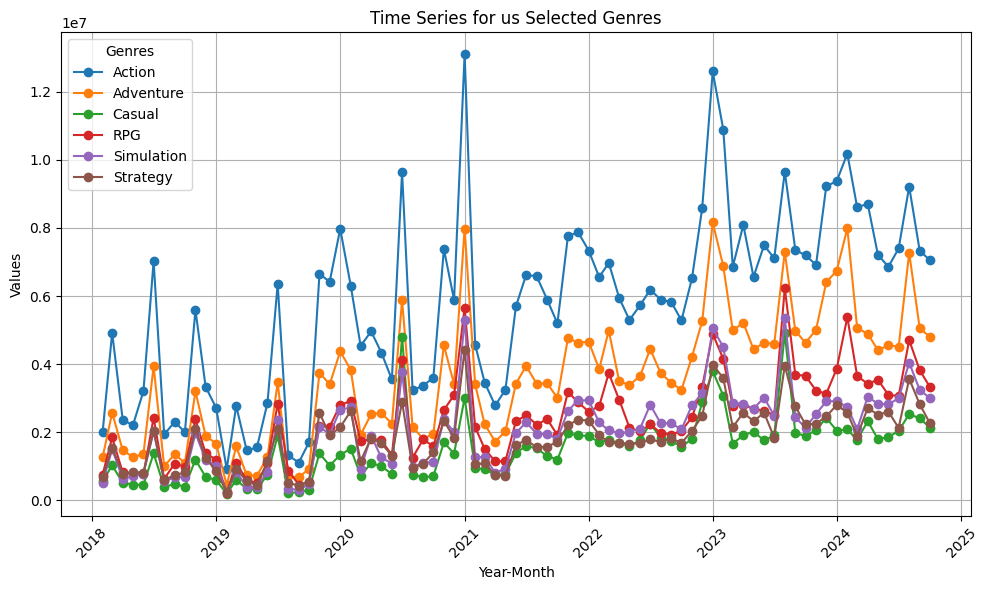

In [19]:
def plot_country_genres_time_series(df, country_code):
    # 指定要繪製的遊戲類型（這些類型應該對應到 DataFrame 的欄位名稱）
    genres = ['Action', 'Adventure', 'RPG', 'Strategy', 'Simulation', 'Casual']
    
    # 根據國家名稱前兩個字母來篩選出相關欄位
    matching_columns = [col for col in df.columns if col[:2] == country_code and any(genre in col for genre in genres)]
    
    # 檢查是否有匹配的欄位
    if not matching_columns:
        print(f"找不到與 '{country_code}' 及指定遊戲類型匹配的欄位。")
        return
    
    # 將 year_month 轉換為日期格式
    df['year_month'] = pd.to_datetime(df['year_month'])
    
    # 繪製匹配的時間序列折線圖
    plt.figure(figsize=(10, 6))
    
    for col in matching_columns:
        genre_label = col[3:]  # 移除前兩個字符及下劃線，只保留遊戲類型名稱
        plt.plot(df['year_month'], df[col], marker='o', linestyle='-', label=genre_label)
    
    # 設置圖例和其他圖表屬性
    plt.title(f'Time Series for {country_code} Selected Genres')
    plt.xlabel('Year-Month')
    plt.ylabel('Values')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Genres")
    
    # 顯示圖表
    plt.tight_layout()
    plt.show()

# 使用函數
plot_country_genres_time_series(df_sales_grouped, 'us')



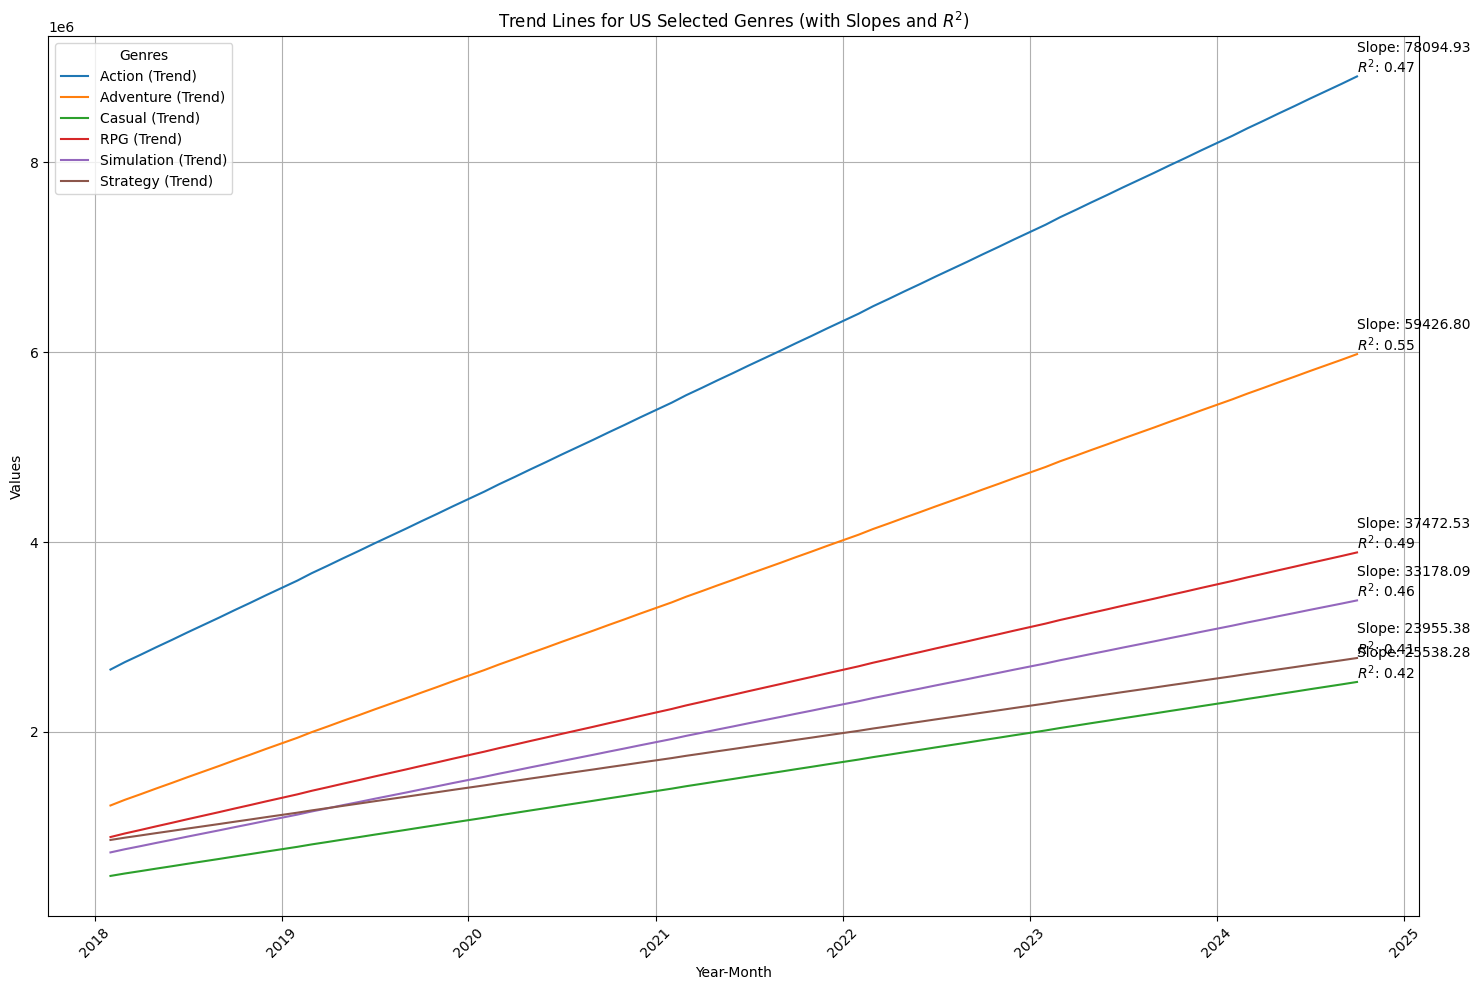

In [32]:
def plot_country_genres_trend_lines_with_slope(df, country_code):
    # 指定要繪製的遊戲類型（這些類型應該對應到 DataFrame 的列名）
    genres = ['Action', 'Adventure', 'RPG', 'Strategy', 'Simulation', 'Casual']
    
    # 根據國家代碼和遊戲類型進行column的篩選
    matching_columns = [
        col for col in df.columns 
        if col[:2] == country_code and any(genre in col for genre in genres)
    ]
    
    # 檢查是否有匹配到的column
    if not matching_columns:
        print(f"找不到與 '{country_code}' 及指定游戏類型相符合的資料。")
        return
    
    # 將 year_month 轉換為日期格式並生成數值 x 軸
    df['year_month'] = pd.to_datetime(df['year_month'])
    x_values = np.arange(len(df['year_month']))
    
    # 繪製匹配的遊戲類型趨勢線圖
    plt.figure(figsize=(15, 10))
    
    for col in matching_columns:
        genre_label = col[3:]  # 移除前兩位字元，只保留遊戲類型名稱
        y_values = df[col].values
        
        # 計算線性回歸
        z = np.polyfit(x_values, y_values, 1)  # 1 表示一階多項式（線性趨勢線）
        p = np.poly1d(z)
        y_pred = p(x_values)
        
        # 計算 R² 值
        y_mean = np.mean(y_values)
        ss_tot = np.sum((y_values - y_mean) ** 2)
        ss_res = np.sum((y_values - y_pred) ** 2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # 繪製趨勢線
        plt.plot(df['year_month'], y_pred, linestyle='-', label=f'{genre_label} (Trend)')
        
        # 標註斜率和 R² 值
        slope = z[0]  # 斜率是 polyfit 返回的第一個值
        text_x = df['year_month'].iloc[-1]
        text_y = y_pred[-1]
        plt.text(
            text_x, text_y, 
            f'Slope: {slope:.2f}\n$R^2$: {r_squared:.2f}', 
            fontsize=10, color='black', verticalalignment='bottom'
        )

    # 設置圖例和其他屬性
    plt.title(f'Trend Lines for {country_code.upper()} Selected Genres (with Slopes and $R^2$)')
    plt.xlabel('Year-Month')
    plt.ylabel('Values')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Genres")
    
    # 顯示圖表
    plt.tight_layout()
    plt.show()

# 使用函數
plot_country_genres_trend_lines_with_slope(df_sales_grouped, 'us')


